In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from libs import plot_exponential_growth, fmt_worktime
from model_params import doubling_time
from model_data import model_data

print("Loaded libraries")

## START task length (displayed in sec) ##
{1: 1.0,
 5: 1.0,
 10: 1.0,
 20: 1.0,
 30: 1.87,
 40: 3.94,
 50: 7.68,
 60: 15.03,
 70: 30.43,
 80: 69.11,
 90: 217.16,
 95: 564.37,
 99: 3145.9}



## AGI task length (displayed in hrs) ##
{1: 40,
 5: 50,
 10: 79,
 20: 138,
 30: 208,
 40: 292,
 50: 400,
 60: 550,
 70: 773,
 80: 1149,
 90: 1987,
 95: 3167,
 99: 7477}



## DOUBLING TIME (displayed in days) ##
{1: 95,
 5: 118,
 10: 118,
 20: 118,
 30: 134,
 40: 159,
 50: 185,
 60: 212,
 70: 212,
 80: 212,
 90: 222,
 95: 253,
 99: 317}



## SHIFT (displayed in days) ##
{1: 0,
 5: 30,
 10: 57,
 20: 89,
 30: 112,
 40: 132,
 50: 150,
 60: 168,
 70: 188,
 80: 212,
 90: 244,
 95: 270,
 99: 320}
Loaded libraries


In [2]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
ref_model = 'gpt5'
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: GPT5 at {model_data[ref_model]['performance_50p']:.1f}hr on {model_data[ref_model]['launch_date'].strftime('%Y-%m-%d')}")
print("=" * 70)
print()


# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)


quarters = []
for year in range(2025, 2030):
    start_q = 3 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)

print(
    f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}"
)
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_gpt5 = (quarter_date - model_data[ref_model]['launch_date']).days

    if days_from_gpt5 < 0:
        continue

    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        doublings = days_from_gpt5 / tau_samples[i]
        task_lengths[i] = model_data[ref_model]['performance_50p'] * (2**doublings)

    task_lengths = np.minimum(task_lengths, 2000)

    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)

    ci_str = f"[{fmt_worktime(p5)} - {fmt_worktime(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")

    print(
        f"{year}Q{q:<7} {date_str:<12} {fmt_worktime(mean_val):<10} {fmt_worktime(median_val):<10} {ci_str:<25} {days_from_gpt5:>4}"
    )

    results.append(
        {
            "quarter": f"{year}Q{q}",
            "date": quarter_date,
            "mean": mean_val,
            "median": median_val,
            "p5": p5,
            "p95": p95,
            "days": days_from_gpt5,
            "task_lengths": task_lengths,
        }
    )

    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [
    (2, "2 hours"),
    (4, "4 hours"),
    (8, "1 day"),
    (16, "2 days"),
    (24, "3 days"),
    (40, "1 week"),
    (174, "1 month"),
]

for hours, name in milestones:
    for r in results:
        if r["median"] >= hours:
            prob = np.mean(r["task_lengths"] >= hours) * 100
            date_str = r["date"].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: GPT5 at 2.3hr on 2025-08-07

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q3       2025-09-30   2.9hr      2.8hr      [2.6hr - 3.1hr]             54
2025Q4       2025-12-31   4.3hr      3.9hr      [3.4hr - 5.4hr]            146

2026Q1       2026-03-31   6.5hr      5.5hr      [4.4hr - 1.1d]             236
2026Q2       2026-06-30   1.3d       7.7hr      [5.6hr - 1.9d]             327
2026Q3       2026-09-30   2.0d       1.4d       [7.2hr - 3.3d]             419
2026Q4       2026-12-31   3.2d       1.9d       [1.2d - 1.1wk]             511

2027Q1       2027-03-31   1.0wk      2.7d       [1.5d - 2.0wk]             601
2027Q2       2027-06-30   1.7wk      3.7d       [1.9d - 3.3wk]             692
2027Q3       2027-09-30   2.8wk      1.0wk      [2.5d - 5.7wk]             784
2027Q4       2027-12-31

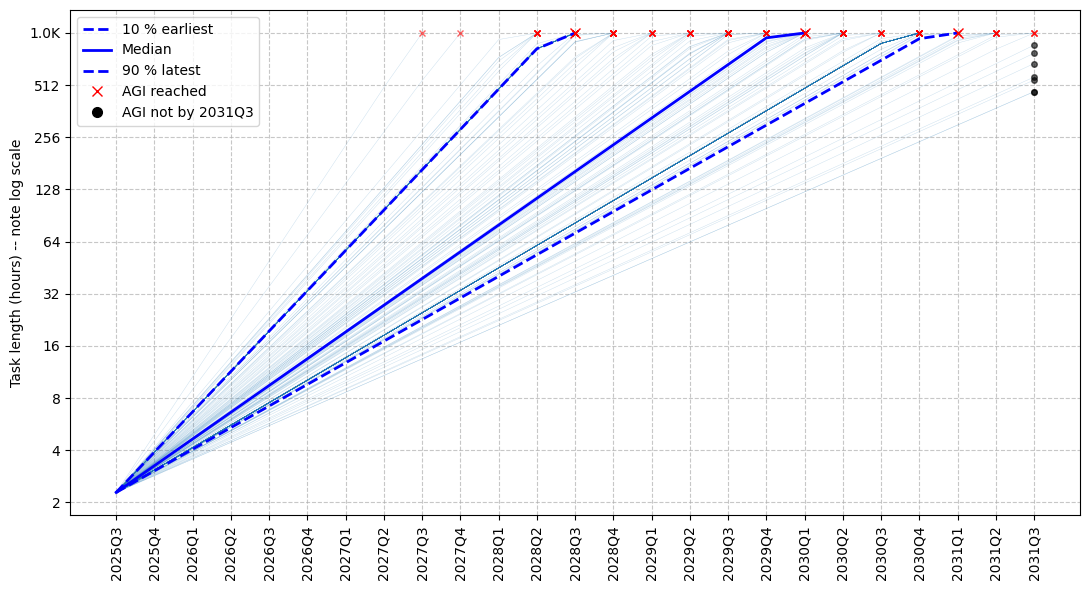

In [3]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    start_hours=model_data[ref_model]['performance_50p'],
    start_date=model_data[ref_model]['launch_date'],
    agi_task_length=100_000,
    shift=0,
    n_quarters=24,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [4]:
def predict(from_model, for_model, debug=False):
    if isinstance(from_model, str):
        from_model = model_data[from_model]
    if isinstance(for_model, str):
        for_model = model_data[for_model]

    print(f"PREDICT {from_model['name']} -> {for_model['name']}")
    days_since = (for_model['launch_date'] - from_model['launch_date']).days

    def extrapolation():
        individual_model_idiosyncratic_variation = sq.norm(0.75, 1/0.75, lclip=0.1)
        doublings = days_since / doubling_time
        return from_model['performance_50p'] * (2**doublings) * individual_model_idiosyncratic_variation

    if debug:
        return {'from_model': from_model,
                'for_model': for_model,
                'days_since': days_since,
                'doubling_time': doubling_time,
                'doublings': days_since / doubling_time,
                'from_perf': from_model['performance_50p']}
    else:
        samples = sq.sample(extrapolation, n=50_000, verbose=True)
        mean_ci = sq.get_mean_and_ci(samples)
        print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")
    
        if for_model.get('performance_50p'):
            print(f"Actual observed: {for_model['name']} at {for_model['performance_50p']:.1f}hr")
        return samples

_ = predict(from_model='o3', for_model='claude_4_opus')

PREDICT o3 -> Claude 4 Opus


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 6763.53it/s]

Predicted: 2.1hr (1.5hr - 2.7hr)
Actual observed: Claude 4 Opus at 1.3hr


In [5]:
_ = predict(from_model='o3', for_model='gpt5')

PREDICT o3 -> GPT5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 6850.95it/s]

Predicted: 3.0hr (2.0hr - 4.2hr)
Actual observed: GPT5 at 2.3hr


In [6]:
_ = predict(from_model='o3', for_model={'name': 'TODAY', 'launch_date': datetime.now()})

PREDICT o3 -> TODAY


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 6967.93it/s]

Predicted: 3.9hr (2.4hr - 6.0hr)


In [7]:
_ = predict(from_model='gpt5', for_model={'name': 'TODAY', 'launch_date': datetime.now()})

PREDICT GPT5 -> TODAY


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7223.57it/s]

Predicted: 3.1hr (2.2hr - 4.1hr)


In [8]:
_ = predict(from_model='o3', for_model='claude_4p5_sonnet')

PREDICT o3 -> Claude 4.5 Sonnet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7213.43it/s]


Predicted: 3.8hr (2.4hr - 5.7hr)


In [9]:
c4o_samples = predict(from_model='claude_4_opus', for_model='claude_4p5_sonnet')

PREDICT Claude 4 Opus -> Claude 4.5 Sonnet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 7058.03it/s]


Predicted: 2.4hr (1.6hr - 3.5hr)


In [10]:
gpt5_samples = predict(from_model='gpt5', for_model='claude_4p5_sonnet')

PREDICT GPT5 -> Claude 4.5 Sonnet


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7181.75it/s]

Predicted: 3.0hr (2.1hr - 3.9hr)


In [11]:
mixed_samples = np.concatenate([c4o_samples, gpt5_samples])
mean_ci = sq.get_mean_and_ci(mixed_samples)
print(f"Predicted: {fmt_worktime(mean_ci['mean'])} ({fmt_worktime(mean_ci['ci_low'])} - {fmt_worktime(mean_ci['ci_high'])})")

Predicted: 2.7hr (1.7hr - 3.8hr)
